<img src="https://www.lsce.ipsl.fr/Css/img/banniere_LSCE_75.png" width="600px">

## Conservative regridding using xESMF - conservative_normed method

### Example with a paleo orca 2.3 configuration

- Author: Patrick Brockmann
- Version: 18/10/2022

#### Sources:
 * https://pangeo-xesmf.readthedocs.io/en/latest/notebooks/Compare_algorithms.html
 *  https://pangeo-xesmf.readthedocs.io/en/latest/notebooks/Masking.html
 *  https://pavics-sdi.readthedocs.io/en/latest/notebooks/regridding.html

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
print(xr.__version__)

2022.3.0


In [2]:
import xesmf as xe
print(xe.__version__)

0.6.3


In [3]:
import cartopy
import cartopy.crs as ccrs
print(cartopy.__version__)

0.21.0


In [4]:
import cf_xarray
print(cf_xarray.__version__)

0.7.4


In [5]:
ds1 = xr.open_dataset("https://thredds-su.ipsl.fr/thredds/dodsC/tgcc_thredds/store/p25camil/IPSLCM5A2/PROD/piControl/C14Ma-1.5PAL/OCE/Analyse/TS_MO/C14Ma-1.5PAL_18500101_20791230_1M_tos.nc")
ds1

<xarray.Dataset>
Dimensions:               (y: 149, x: 182, deptht: 31, time_counter: 2760,
                           axis_nbounds: 2)
Coordinates:
    nav_lat               (y, x) float32 ...
    nav_lon               (y, x) float32 ...
  * deptht                (deptht) float32 5.0 15.0 25.0 ... 4.75e+03 5.25e+03
    time_centered         (time_counter) object ...
  * time_counter          (time_counter) object 1850-01-16 00:00:00 ... 2079-...
Dimensions without coordinates: y, x, axis_nbounds
Data variables:
    time_centered_bounds  (time_counter, axis_nbounds) object ...
    tos                   (time_counter, y, x) float32 ...
Attributes:
    _NCProperties:                   version=1|netcdflibversion=4.6.0|hdf5lib...
    name:                            C14Ma-1.5PAL_1m_grid_T
    description:                     Created by xios
    title:                           Created by xios
    Conventions:                     CF-1.6
    timeStamp:                       2019-Sep-26 15:35:17 GMT
    uuid:                            15d8aee5-1913-4dcb-abb3-d7de920a72a0
    LongName:                        IPSLCM5A2
    history:                         Fri Sep 27 15:57:18 2019: ncrcat -C --bu...
    NCO:                             "4.6.0"
    nco_openmp_thread_number:        1
    DODS_EXTRA.Unlimited_Dimension:  time_counter

Max : 35.021797
Min : 10.233334


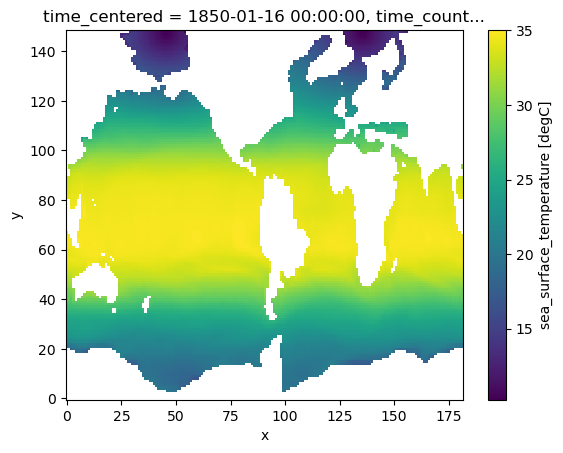

In [6]:
ds1_select = ds1['tos'].isel(time_counter=0)
ds1_select.plot(cmap='viridis')
print("Max : %f\nMin : %f" %(ds1_select.max(), ds1_select.min()))

In [7]:
print("%d" %(ds1_select).count())

16586


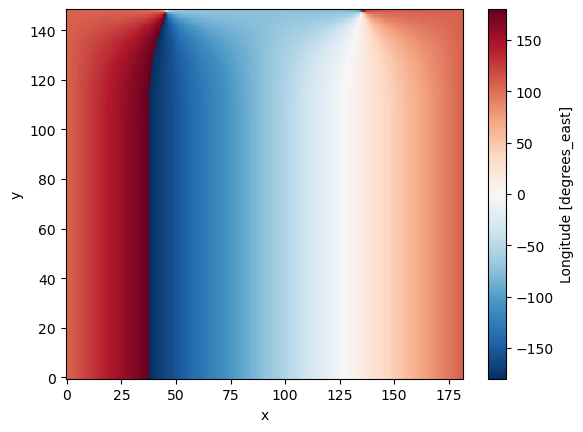

In [8]:
ds1['nav_lon'].plot()

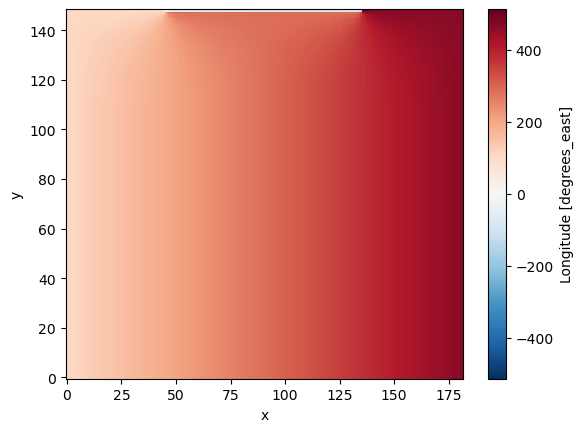

In [9]:
fixed_lons = ds1["nav_lon"].copy()
for i, start in enumerate(np.argmax(np.abs(np.diff(ds1["nav_lon"])) > 180, axis=1)):
    fixed_lons[i, start+1:] += 360
fixed_lons.plot()

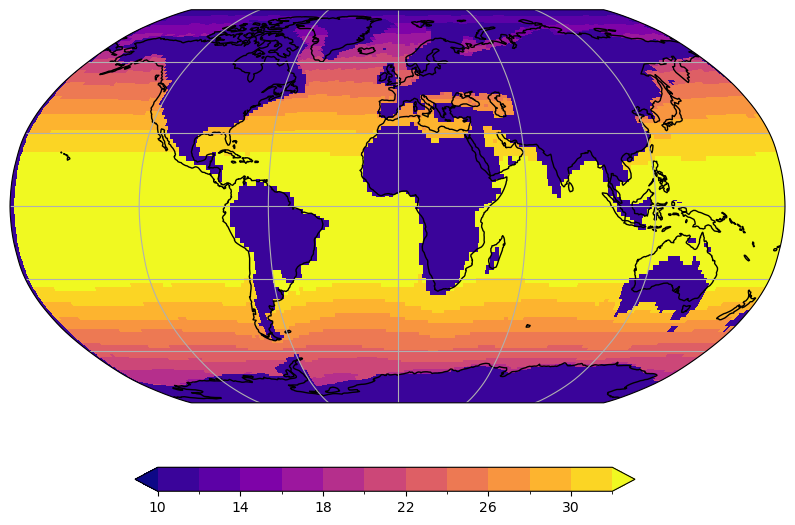

In [10]:
levels = np.arange(10, 34, 2)
colors = plt.cm.plasma(np.linspace(0, 1, len(levels)+1))
cmap, norm = matplotlib.colors.from_levels_and_colors(levels, colors, extend='both')

#==================================
fig = plt.figure(figsize=(10,6))
ax = plt.subplot(1, 1, 1, projection=ccrs.Robinson(0))
ax.pcolormesh(fixed_lons , 
              ds1["nav_lat"], 
              ds1_select, 
              transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
ax.coastlines()
ax.gridlines()

#==================================
fig.subplots_adjust(wspace=0.02, hspace=0.02)
cb_ax = fig.add_axes([0.25, 0.02, 0.5, 0.04])
matplotlib.colorbar.ColorbarBase(cb_ax, norm=norm, cmap=cmap, orientation='horizontal', extend='both')

#==================================
plt.show()

In [11]:
ds1Grid = xr.open_dataset("https://thredds-su.ipsl.fr/thredds/dodsC/ipsl_thredds/brocksce/PALEORCA2.3/14Ma/IPSL.PALEORCA2_gridCF.nc")
ds1Grid

<xarray.Dataset>
Dimensions:       (y: 149, x: 182, four: 4, depth: 31, two: 2)
Coordinates:
    lon           (y, x) float32 ...
    lat           (y, x) float32 ...
  * depth         (depth) float32 5.0 15.0 25.0 ... 4.25e+03 4.75e+03 5.25e+03
Dimensions without coordinates: y, x, four, two
Data variables:
    bounds_lon    (y, x, four) float32 ...
    bounds_lat    (y, x, four) float32 ...
    bounds_depth  (depth, two) float32 ...
    MASK          (depth, y, x) float32 ...
    MASKDRAW      (depth, y, x) float32 ...
    VOL           (depth, y, x) float32 ...
    AREA          (y, x) float32 ...
    BATHY         (y, x) float32 ...
Attributes:
    Conventions:  CF-1.1
    institution:  PALEORCA2
    production:   NEMO

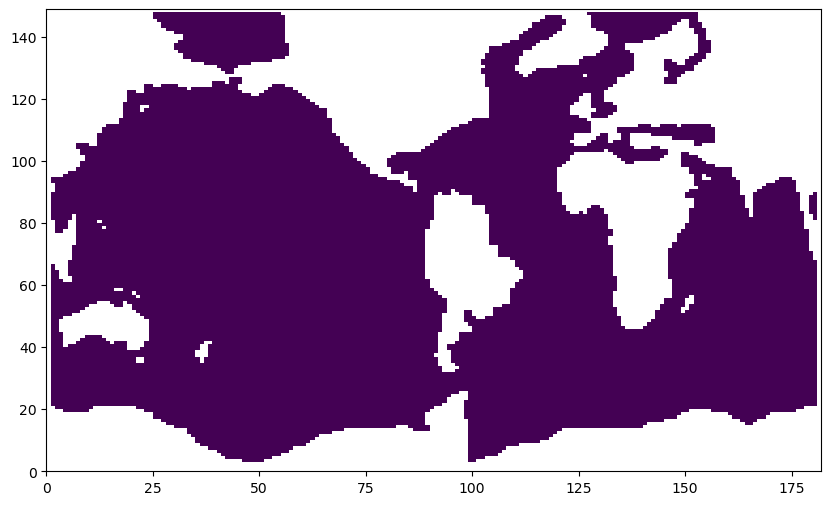

In [12]:
# MASKDRAW and MASK seems to have been exchanged
mask = xr.where(ds1Grid['MASKDRAW'].isel(depth=0) == 1, 1, np.nan)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.pcolormesh(mask)

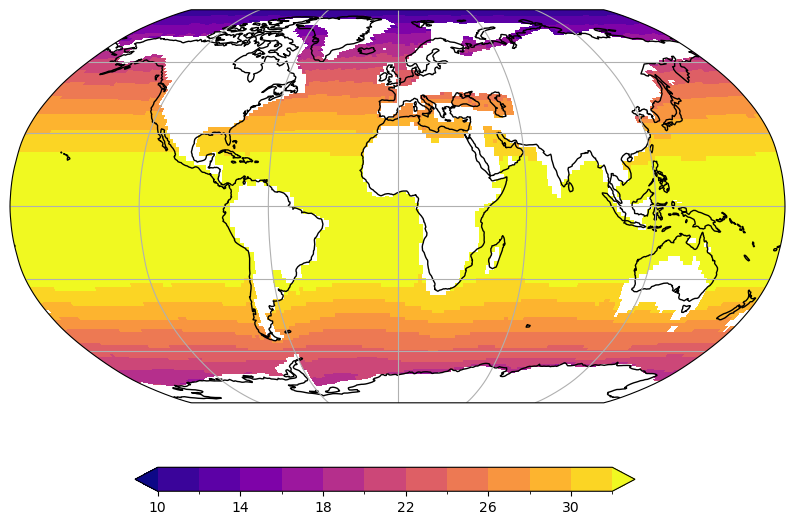

In [13]:
levels = np.arange(10, 34, 2)
colors = plt.cm.plasma(np.linspace(0, 1, len(levels)+1))
cmap, norm = matplotlib.colors.from_levels_and_colors(levels, colors, extend='both')

#==================================
fig = plt.figure(figsize=(10,6))
ax = plt.subplot(1, 1, 1, projection=ccrs.Robinson(0))
ax.pcolormesh(fixed_lons , 
              ds1["nav_lat"], 
              ds1_select*mask, 
              transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
ax.coastlines()
ax.gridlines()

#==================================
fig.subplots_adjust(wspace=0.02, hspace=0.02)
cb_ax = fig.add_axes([0.25, 0.02, 0.5, 0.04])
matplotlib.colorbar.ColorbarBase(cb_ax, norm=norm, cmap=cmap, orientation='horizontal', extend='both')

#==================================
plt.show()

In [14]:
weights = ds1Grid['AREA']
a = ds1_select
a_weighted = a.weighted(weights)
a_masked = ds1_select*mask
a_masked_weighted = a_masked.weighted(weights)

print("========= Non masked\n %d cells" % a.count())
print("average : %f\naverage weigted : %f" % (a.mean(), a_weighted.mean()))

print("========= Masked\n %d cells" % a_masked.count())
print("average : %f\naverage weigted : %f" % (a_masked.mean(), a_masked_weighted.mean()))

========= Non masked
 16586 cells
average : 28.262560
average weigted : 30.075548
========= Masked
 16416 cells
average : 28.306190
average weigted : 30.092350


In [15]:
ds1Grid["bounds_lon"].dims[-1]

'four'

In [16]:
blon = cf_xarray.bounds_to_vertices(ds1Grid["bounds_lon"], ds1Grid["bounds_lon"].dims[-1])
blat = cf_xarray.bounds_to_vertices(ds1Grid["bounds_lat"], ds1Grid["bounds_lat"].dims[-1])
blon

<xarray.DataArray 'bounds_lon' (y_vertices: 150, x_vertices: 183)>
array([[ 106.      ,  108.      ,  110.      , ...,  466.      ,
         468.      ,  466.      ],
       [ 106.      ,  108.      ,  110.      , ...,  466.      ,
         468.      ,  466.      ],
       [ 106.      ,  108.      ,  110.      , ...,  466.      ,
         468.      ,  466.      ],
       ...,
       [ 106.      ,  106.      ,  106.      , ...,  466.      ,
         466.      ,  466.      ],
       [ 106.      ,  106.      ,  106.      , ..., -254.      ,
        -254.      , -254.      ],
       [ 106.002625,  106.      ,  105.997375, ..., -253.99738 ,
        -254.      , -254.00262 ]], dtype=float32)
Dimensions without coordinates: y_vertices, x_vertices

In [17]:
ds_in = xr.Dataset()
ds_in["mask"] = xr.where(ds1Grid['MASKDRAW'].isel(depth=0) == 1, 1, 0)
ds_in["lon_b"] = blon
ds_in["lat_b"] = blat
ds_in

<xarray.Dataset>
Dimensions:  (y: 149, x: 182, y_vertices: 150, x_vertices: 183)
Coordinates:
    lon      (y, x) float32 105.0 107.0 109.0 111.0 ... -254.0 -254.0 -254.0
    lat      (y, x) float32 -78.19 -78.19 -78.19 -78.19 ... 59.91 59.91 59.91
    depth    float32 5.0
Dimensions without coordinates: y, x, y_vertices, x_vertices
Data variables:
    mask     (y, x) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    lon_b    (y_vertices, x_vertices) float32 106.0 108.0 ... -254.0 -254.0
    lat_b    (y_vertices, x_vertices) float32 -77.98 -77.98 ... 59.82 59.82

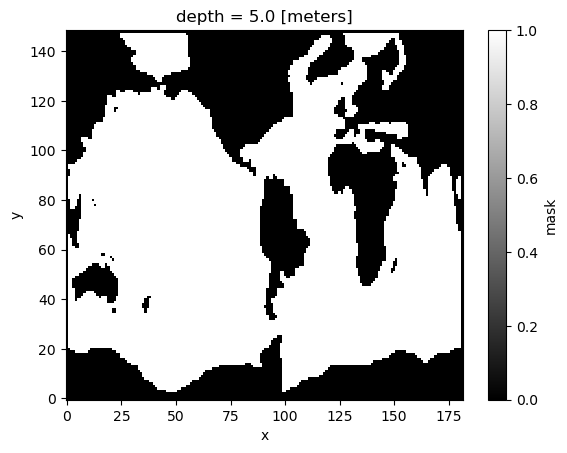

In [18]:
ds_in["mask"].plot(cmap="binary_r")

In [19]:
#ds_topo = xr.open_dataset("https://thredds-su.ipsl.fr/thredds/dodsC/ipsl_thredds/brocksce/PALEORCA2.3/14Ma/TopoFilled_14Ma-HR.nc")
ds_topo = xr.open_dataset("https://thredds-su.ipsl.fr/thredds/dodsC/ipsl_thredds/brocksce/PALEORCA2.3/17Ma/TopoFilled_17Ma-HR.nc")
ds_topo

<xarray.Dataset>
Dimensions:    (longitude: 2160, latitude: 1080)
Coordinates:
  * longitude  (longitude) float64 -179.9 -179.8 -179.6 ... 179.6 179.8 179.9
  * latitude   (latitude) float64 89.92 89.75 89.58 ... -89.58 -89.75 -89.92
Data variables:
    RELIEF     (latitude, longitude) float64 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.4 (http://mpimet.mpg.de/...
    Conventions:  CF-1.6
    history:      Mon Sep  9 14:22:27 2019: ncrename -v topo,RELIEF TopoFille...
    NCO:          netCDF Operators version 4.7.6 (Homepage = http://nco.sf.ne...
    CDO:          Climate Data Operators version 1.9.4 (http://mpimet.mpg.de/...

In [20]:
delta = 1.0
ds_out = xr.Dataset(
    {
        "lat": (["lat"], np.arange(-90 + delta/2, 90, delta)),
        "lon": (["lon"], np.arange(delta/2, 360, delta)),
    }
)
ds_out

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
Data variables:
    *empty*

In [21]:
regridder_bilinear = xe.Regridder(ds_topo, ds_out, "bilinear", periodic=True)
regridder_bilinear

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_1080x2160_180x360_peri.nc 
Reuse pre-computed weights? False 
Input grid shape:           (1080, 2160) 
Output grid shape:          (180, 360) 
Periodic in longitude?      True

In [22]:
ds_topo_bilinear = regridder_bilinear(ds_topo)
ds_topo_bilinear

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
Data variables:
    RELIEF   (lat, lon) float64 701.7 703.8 705.0 ... -5.037e+03 -5.023e+03
Attributes:
    regrid_method:  bilinear

<function matplotlib.pyplot.show(close=None, block=None)>

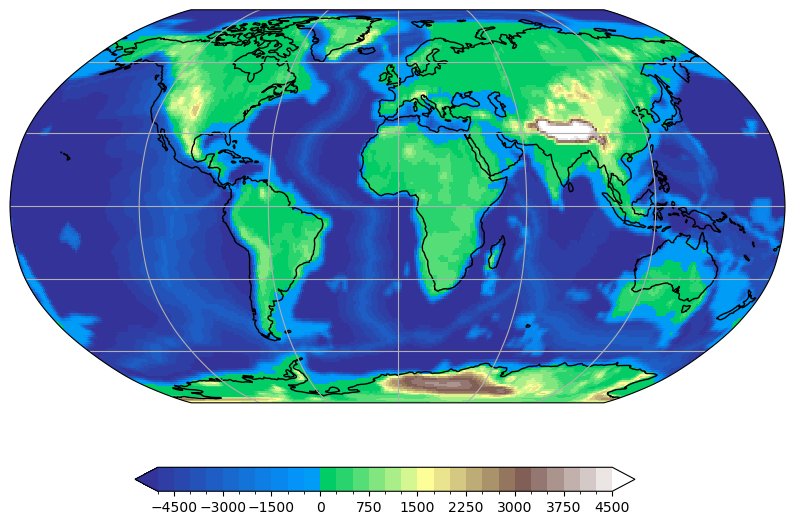

In [23]:
delta = 500 ; levels_undersea = np.arange(-5000, 0, delta)
delta = 250 ; levels_land = np.arange(0, 4500+delta, delta)
levels = np.concatenate((levels_undersea, levels_land))

#  https://matplotlib.org/stable/tutorials/colors/colormapnorms.html#twoslopenorm-different-mapping-on-either-side-of-a-center
colors_undersea = plt.cm.terrain(np.linspace(0, 0.16, len(levels_undersea)+1))
colors_land = plt.cm.terrain(np.linspace(0.25, 1, len(levels_land)))
colors = np.concatenate((colors_undersea, colors_land))

cmap, norm = matplotlib.colors.from_levels_and_colors(levels, colors, extend='both')

#=============================================================
fig = plt.figure(figsize=(10,6))
ax = plt.subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=0))
ax.pcolormesh(ds_topo_bilinear['lon'], 
              ds_topo_bilinear['lat'], 
              ds_topo_bilinear['RELIEF'], 
              transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
ax.coastlines()
ax.gridlines()

#==================================
fig.subplots_adjust(wspace=0.02, hspace=0.02)
cb_ax = fig.add_axes([0.25, 0.02, 0.5, 0.04])
matplotlib.colorbar.ColorbarBase(cb_ax, norm=norm, cmap=cmap, orientation='horizontal', extend='both')

#==================================
plt.show

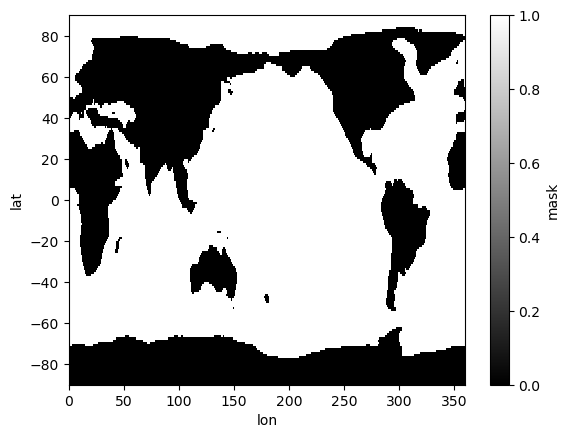

In [24]:
ds_out['mask'] = xr.where(ds_topo_bilinear['RELIEF'] >= 0, 0, 1)
ds_out['mask'].plot(cmap="binary_r")

In [25]:
ds_out

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
Data variables:
    mask     (lat, lon) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1 1 1 1

In [26]:
regridder_conservative = xe.Regridder(ds_in, ds_out, "conservative_normed", 
                                      ignore_degenerate=True, periodic=True)

In [27]:
ds2_conservative = regridder_conservative(ds1_select)
ds2_conservative

<xarray.DataArray (lat: 180, lon: 360)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [11.265236 , 11.265236 , 11.266201 , ..., 11.305076 , 11.287835 ,
        11.268714 ],
       [10.925483 , 10.929703 , 10.933595 , ..., 10.919503 , 10.919503 ,
        10.921018 ],
       [10.650383 , 10.6528845, 10.655191 , ..., 10.641638 , 10.644767 ,
        10.647679 ]], dtype=float32)
Coordinates:
    time_centered  object 1850-01-16 00:00:00
    time_counter   object 1850-01-16 00:00:00
  * lat            (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon            (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
Attributes:
    regrid_method:  conservative_normed

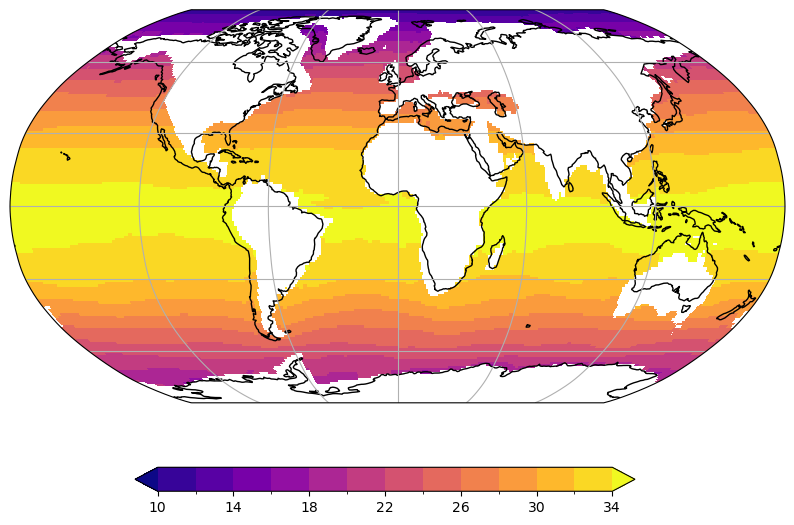

In [28]:
levels = np.arange(10, 35, 2)
cmap = plt.get_cmap('plasma')
colors = cmap(np.linspace(0, 1, len(levels)+1))
cmap, norm = matplotlib.colors.from_levels_and_colors(levels, colors, extend='both')

#==================================
fig = plt.figure(figsize=(10,6))
ax = plt.subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=0))
ax.pcolormesh(ds2_conservative['lon'], ds2_conservative['lat'], ds2_conservative, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
ax.coastlines()
ax.gridlines()

#==================================
fig.subplots_adjust(wspace=0.02, hspace=0.02)
cb_ax = fig.add_axes([0.25, 0.02, 0.5, 0.04])
matplotlib.colorbar.ColorbarBase(cb_ax, norm=norm, cmap=cmap, orientation='horizontal', extend='both')

#==================================
plt.show()

In [29]:
ds2_conservative.name = "var"
ds2_conservative.to_netcdf("convervative_normed.nc", "w")

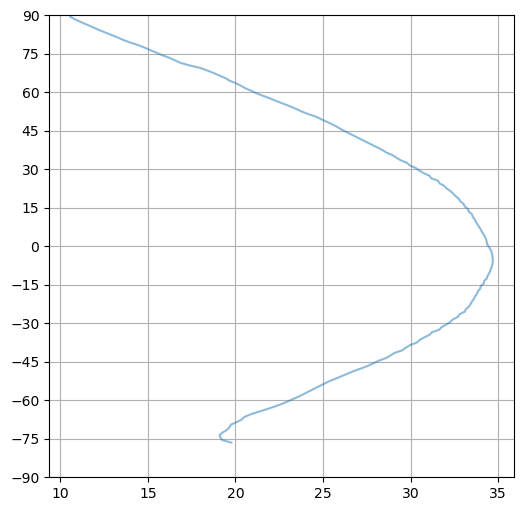

In [30]:
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(1, 1, 1)
c = ds2_conservative.mean(('lon'))
ax.plot(c, c.lat, alpha=0.5)
plt.ylim([-90, 90])
plt.yticks(np.arange(-90,90+15,15))
ax.grid()
plt.show()

In [31]:
# https://ferret.pmel.noaa.gov/Ferret/faq/averages-integrals-on-the-sphere
weights = np.cos(np.deg2rad(ds2_conservative.lat))
a = ds2_conservative
a_weighted = a.weighted(weights)
print('conservative_normed')
print("average : %f\naverage weigted : %f" % (a.mean(), a_weighted.mean()))

conservative_normed
average : 27.373178
average weigted : 30.103751
